# Circular task analysis

The task is described in Fauviaux et al. (2021). The data was recorded with the MouseReMoCo software.

To understand how the data was recorded, you are invited to play with MouseReMoCo on you own computer. Once you really understand how the task works, what is recorded and how to interpret the content of the data files, you can start working on the codding part of this assignment.

NOTE: The coding part of this assignment is not the difficult part. The difficult part is to understand how the data was recorded and how to interpret the content of the data files. So please, take your time to understand the task, carefully read the documentation in the GitHub repository, and explore the task and the data generated on your own computer before starting coding.

## Your mission is to:

#### reproduce the graphics below, using the data files provided in the assignment (001MoDe_R1.csv and 001MoDe_R1.markers.csv).

#### re-compute the values in the table at the end of 001MoDe_R1.markers.csv file using your own code to analyze the data in 001MoDe_R1.csv. 

#### Run your code on a data file that you generated yourself with MouseReMoCo, and include the results in your report.

#### Write a short HTML report (1-2 pages) explaining the most interesting difficulties you encountered and solved, and how you verified that your results are correct.

You will work in teams of 3 students to deliver a public GitHub repository containing your circular task analysis.

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os

# very useful for zoomable plots in Jupyter notebooks
%matplotlib widget

In [3]:
# if the present working directory is the directory of this file, change the path to the project root
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

## Définir les intervalles

{'screenWidth': '1104', 'screenHeight': '661', 'cornerX': '302', 'cornerY': '80', 'centerX': '552', 'centerY': '330', 'externalRadius': '250', 'internalRadius': '170', 'borderRadius': '1', 'cursorRadius': '16', 'indexOfDifficulty': '28.00696429476858', 'taskRadius': '209.5', 'taskTolerance': '47', 'borderColor': 'java.awt.Color[r=255,g=255,b=255]', 'backgroundColor': 'java.awt.Color[r=0,g=0,b=0]', 'cursorColorRecord': 'java.awt.Color[r=255,g=0,b=0]', 'cursorColorWait': 'java.awt.Color[r=255,g=255,b=0]', 'autoStart': '3600', 'cycleMaxNumber': '6', 'cycleDuration': '20', 'software': 'LSL-mouse', 'version': '1.2.0rc5', 'task': 'CircularTarget', 'isWithLSL': 'false'}


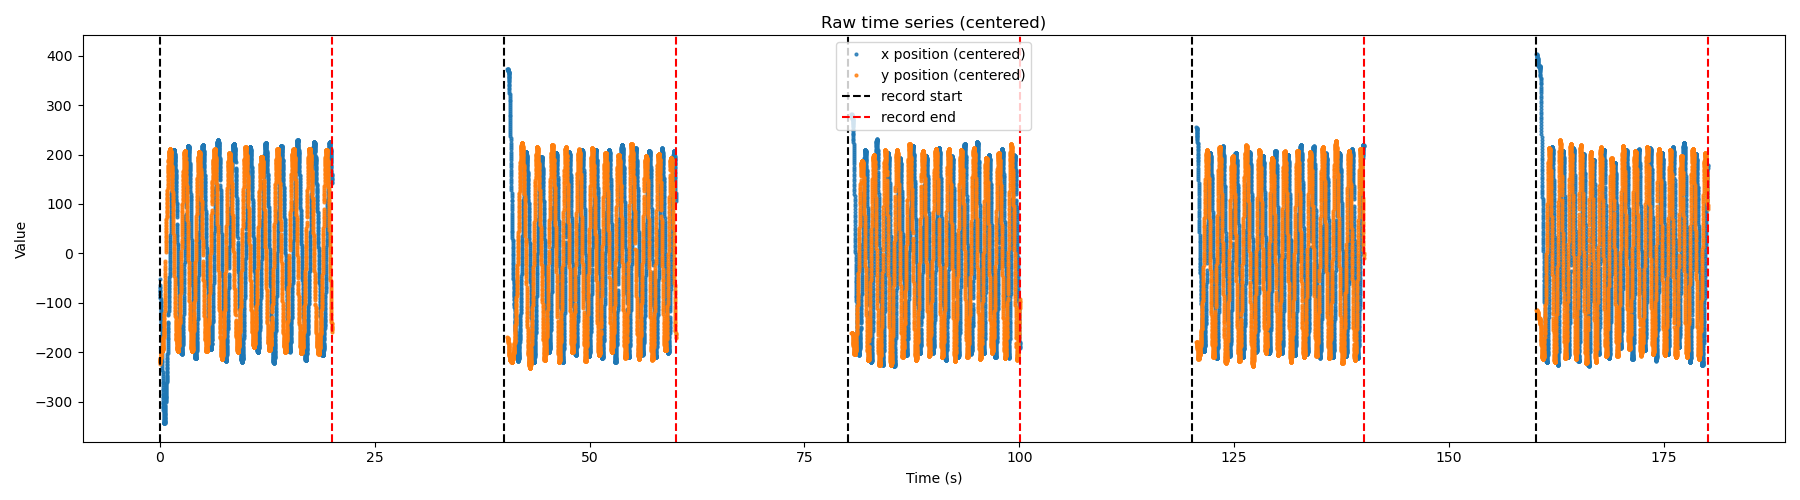

In [4]:
# import files
data_file   = "data/001MoDe_R1.csv" #Pas besoin de mettre tous le chemin d'acces 
marker_file = "data/001MoDe_R1.marker.csv" #Changement _ par . 

# ============================================================
# 1) Lecture du fichier data (coords)
# ============================================================

raw_lines = open(data_file, "r").read().splitlines()
config_line = raw_lines[0]

# extraction du centre X/Y à partir du header
record_config = {}
for part in config_line.split(";"): #Changement "," par ";"
    if " " in part:
        key, value = part.split(" ", 1)
        record_config[key] = value
#print(config_line) 
print(record_config)
cx = float(record_config["centerX"])
cy = float(record_config["centerY"])

data = np.genfromtxt(
    data_file,
    delimiter=",",
    skip_header=3,
    names=True,
    dtype=float
)

data = data[data["timestamp"] > 0]

ts = data["timestamp"]
t = (ts - ts[0]) / 1000.0

# coordonnées centrées
x = data["mouseX"] - cx
y = -(data["mouseY"] - cy)    # inversion axe vertical = convention math

# ============================================================
# 2) Lecture markers
# ============================================================

marker_timestamps = []
marker_labels = []

with open(marker_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        parts = line.split(",", 2)
        if len(parts) < 3:
            continue

        try:
            ts_m = float(parts[1])
        except ValueError:
            continue

        marker_timestamps.append(ts_m)
        marker_labels.append(parts[2])

marker_timestamps = np.array(marker_timestamps)
marker_labels = np.array(marker_labels, dtype=str)

t_markers = (marker_timestamps - ts[0]) / 1000.0

record_starts = t_markers[["DoRecord" in lab for lab in marker_labels]]
record_ends   = t_markers[["DoPause" in lab for lab in marker_labels]]

# ============================================================
# 3) plot
# ============================================================

plt.figure(figsize=(18,5))
plt.plot(t, x,'o', markersize = 2, label="x position (centered)", alpha=0.8)
plt.plot(t, y,'o', markersize = 2, label="y position (centered)", alpha=0.8)

# marqueurs phases
for i, t0 in enumerate(record_starts):
    plt.axvline(t0, color="black", linestyle="--", linewidth=1.5,
                label="record start" if i == 0 else None)

for i, t1 in enumerate(record_ends):
    plt.axvline(t1, color="red", linestyle="--", linewidth=1.5,
                label="record end" if i == 0 else None)

plt.title("Raw time series (centered)")
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1),
    ncol=1,
    frameon=True
)
plt.tight_layout()
plt.show()


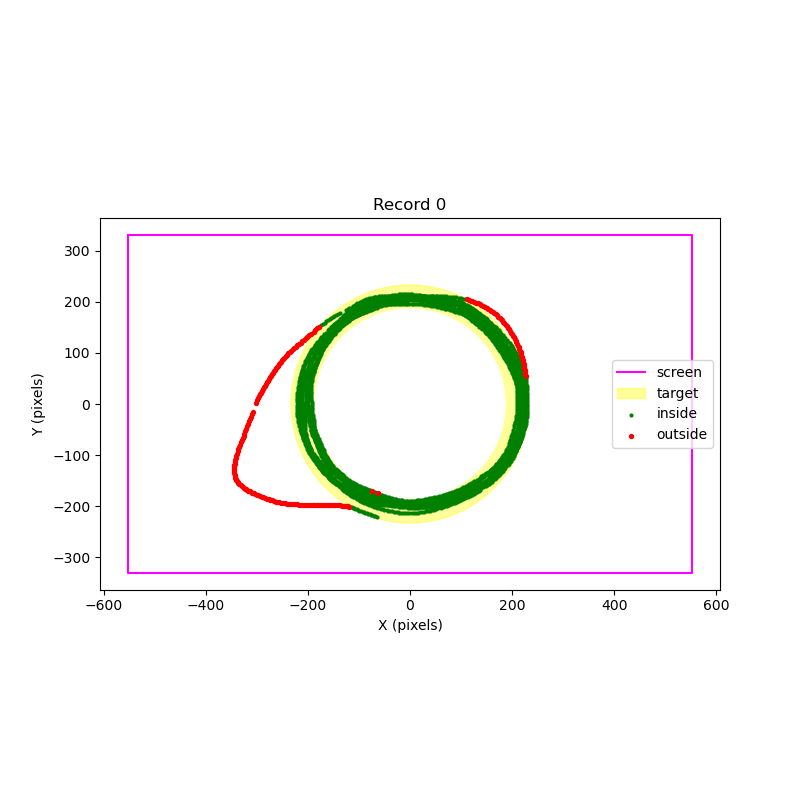

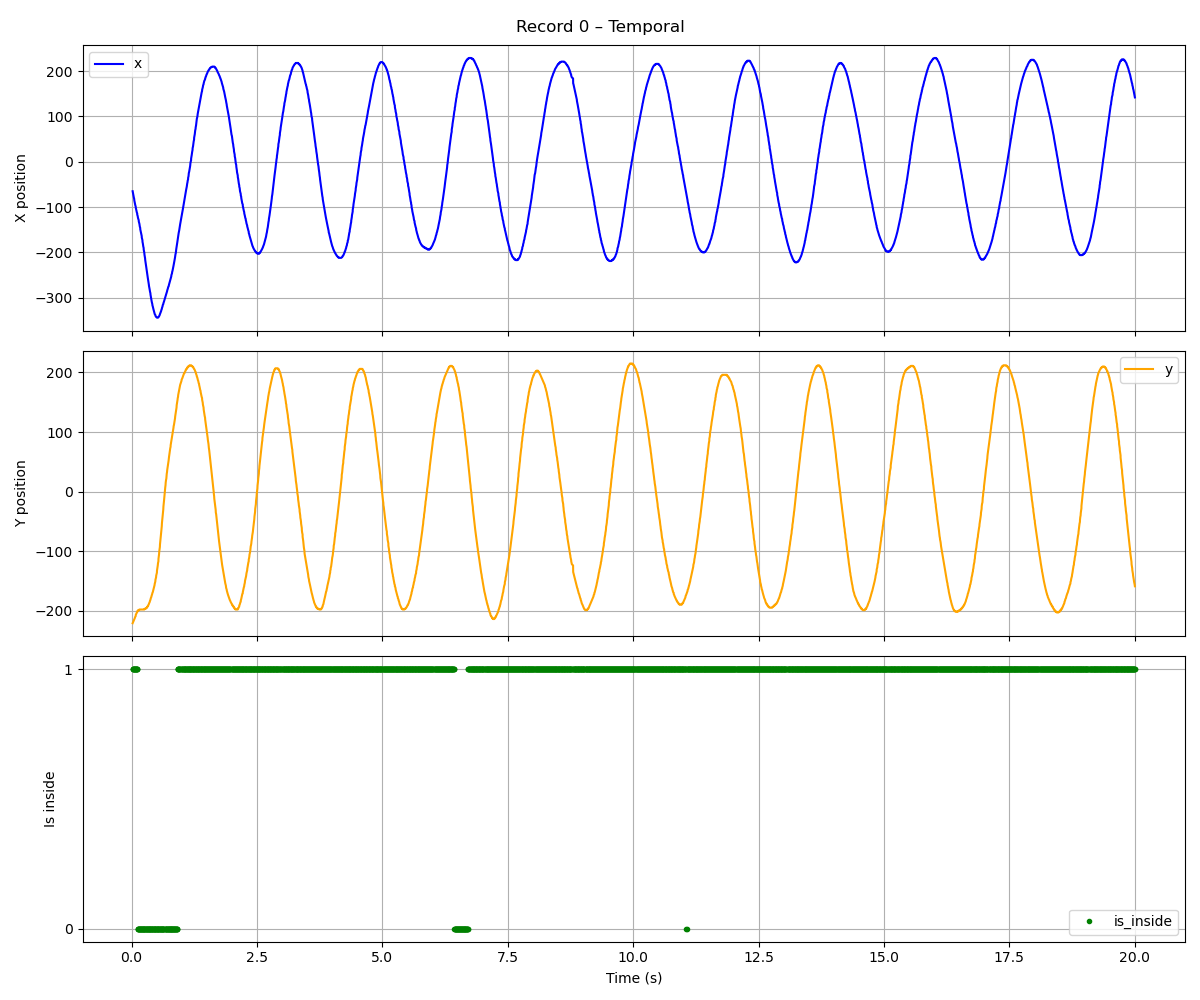

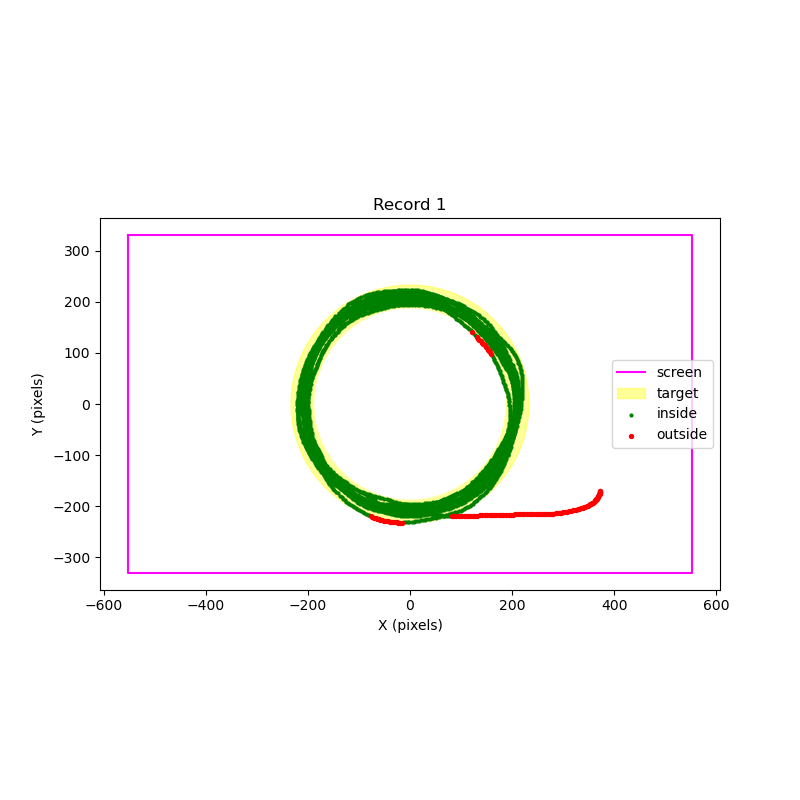

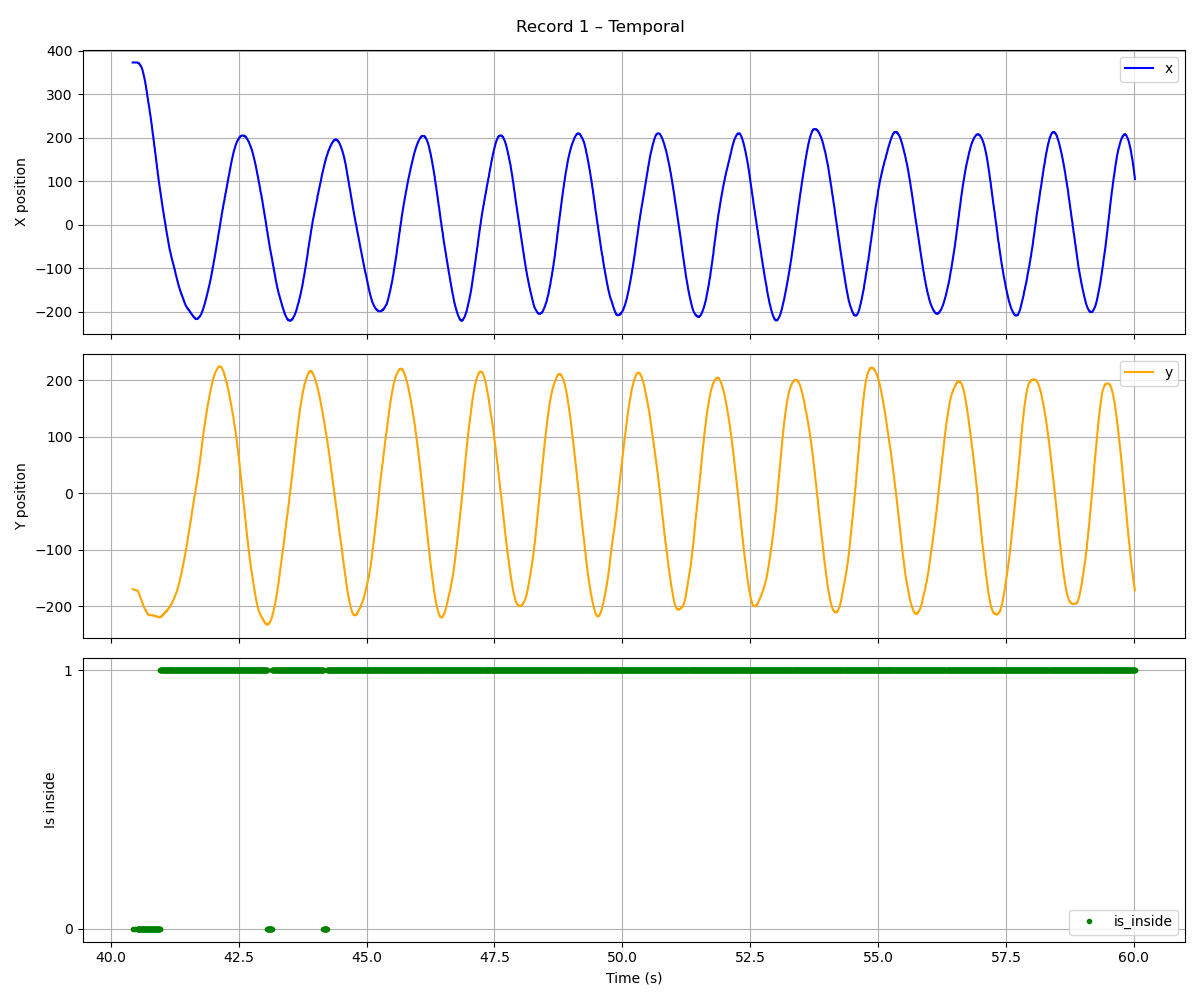

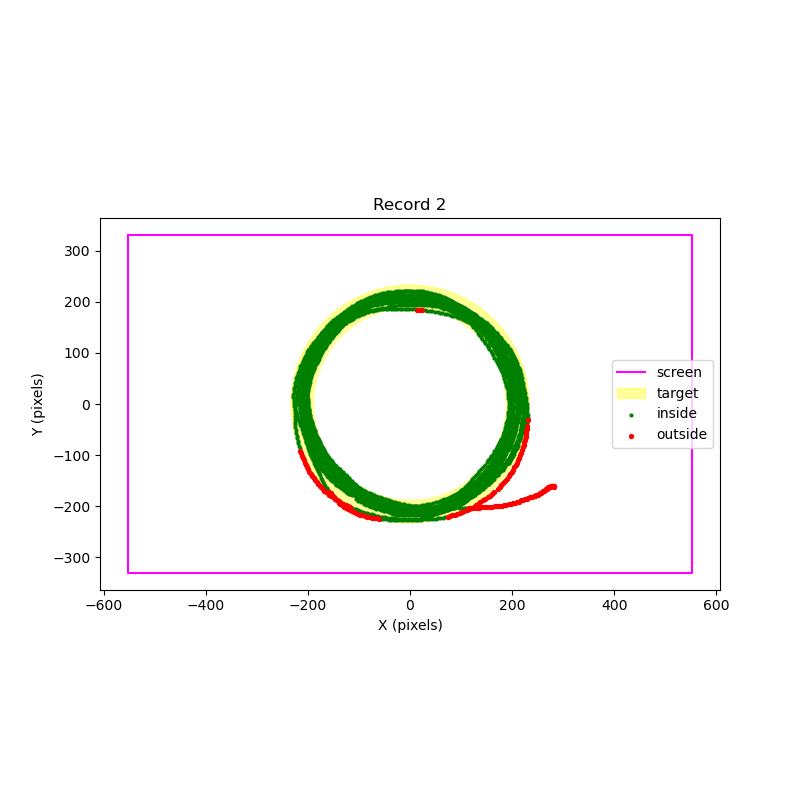

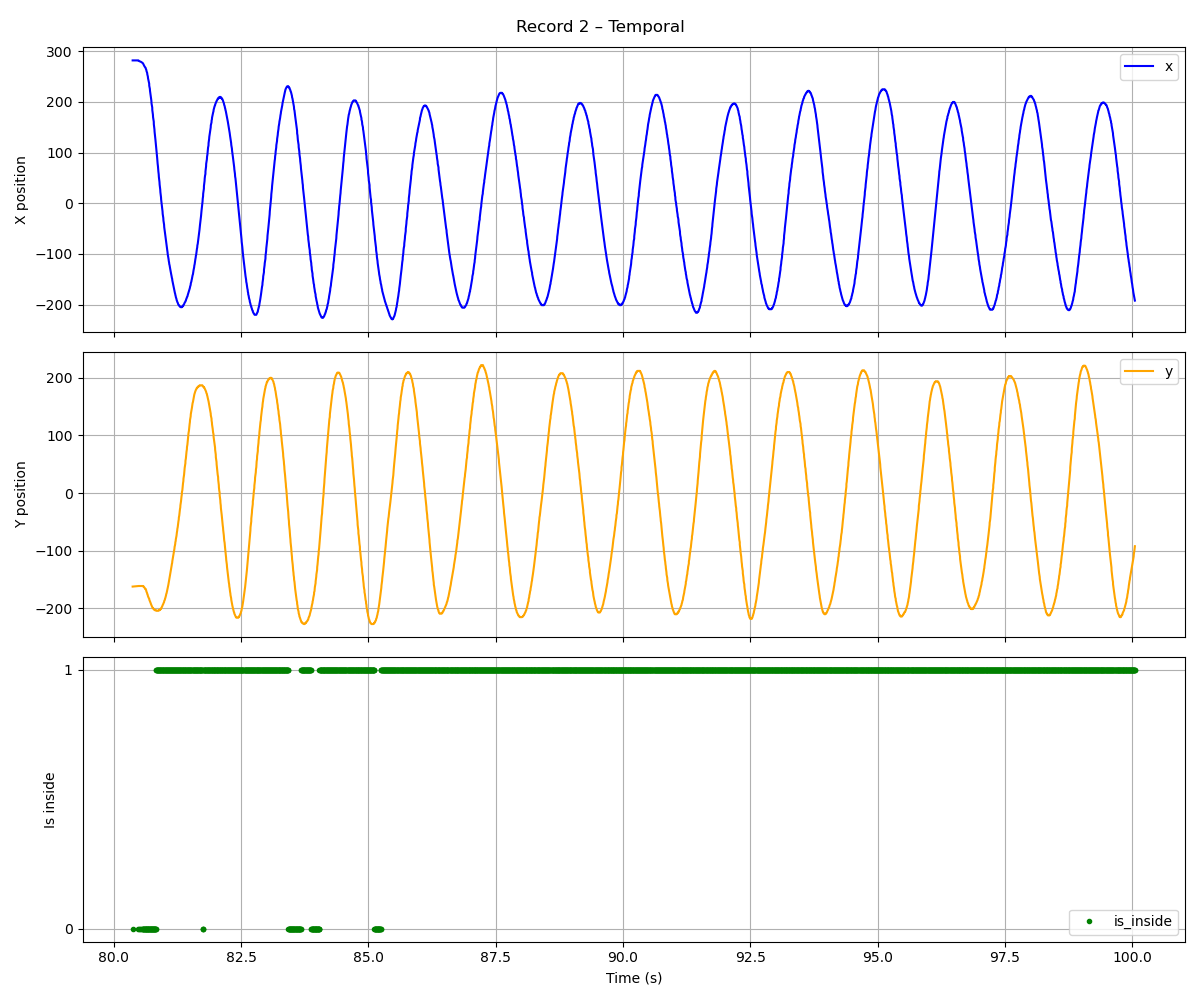

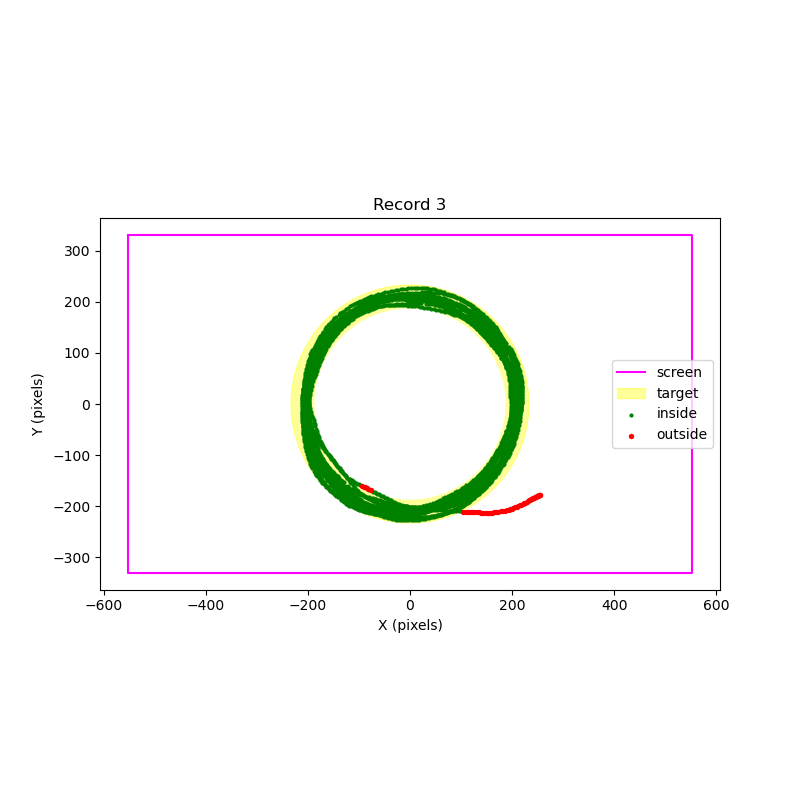

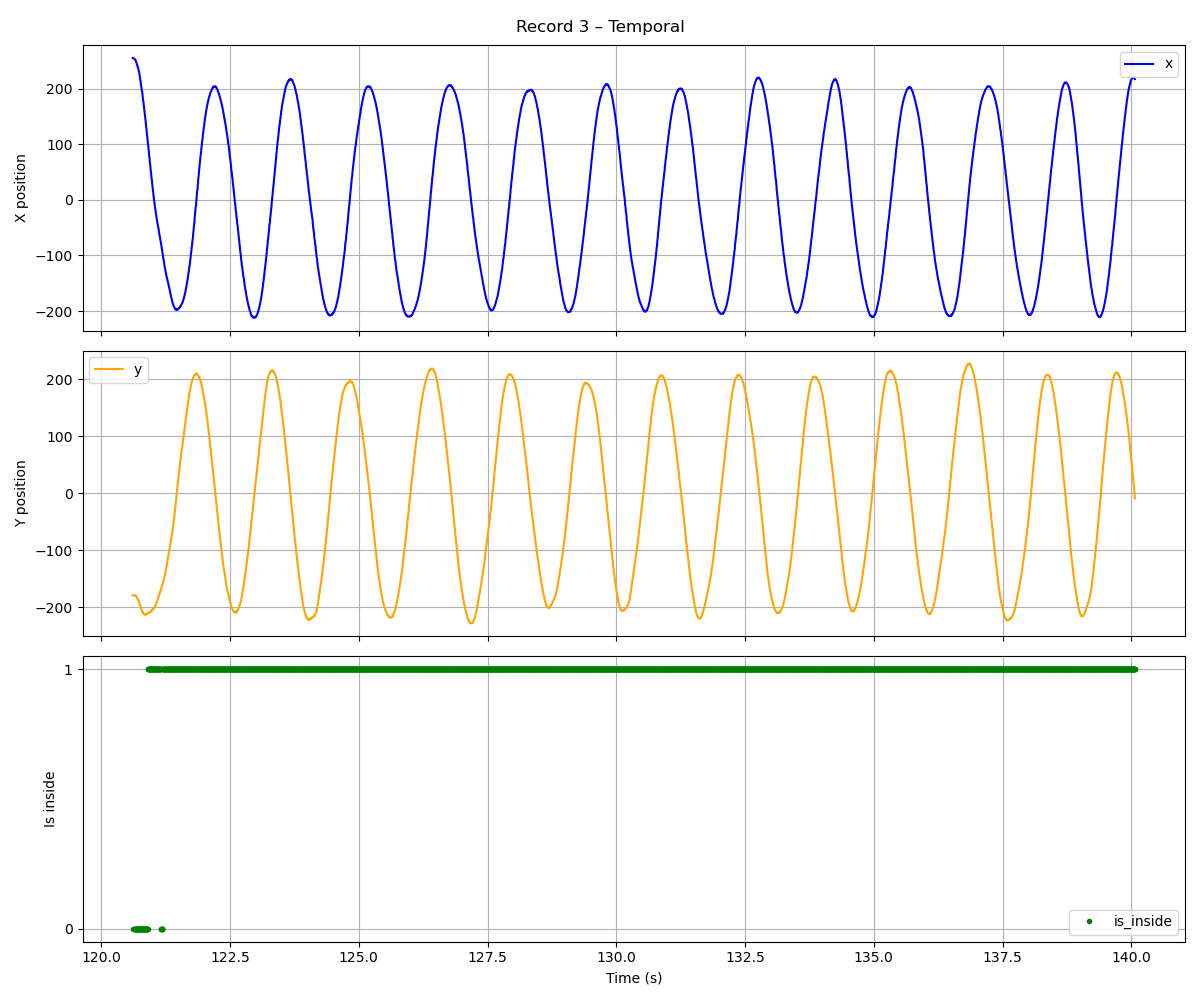

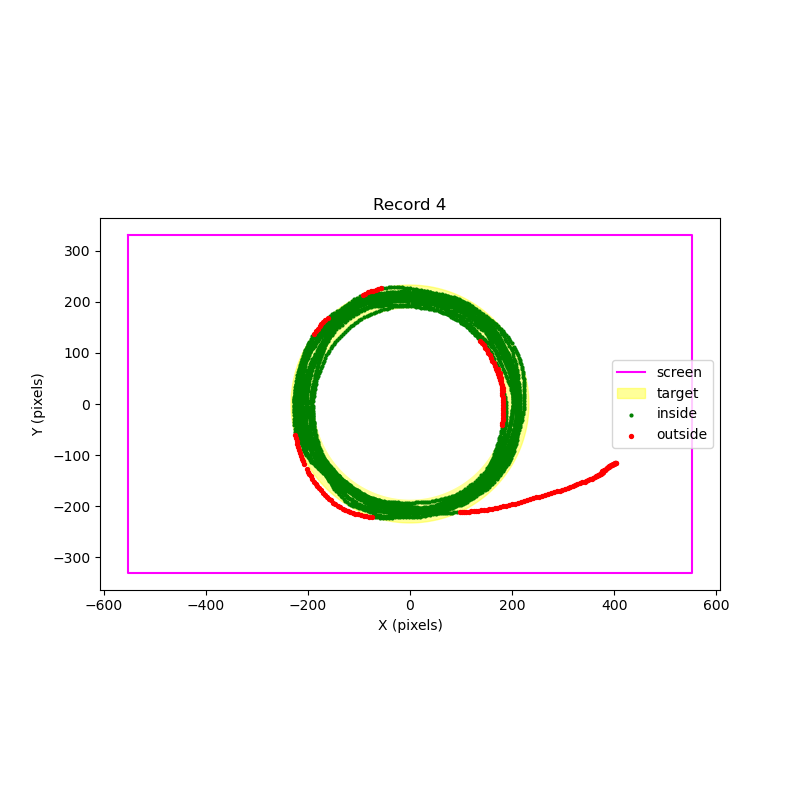

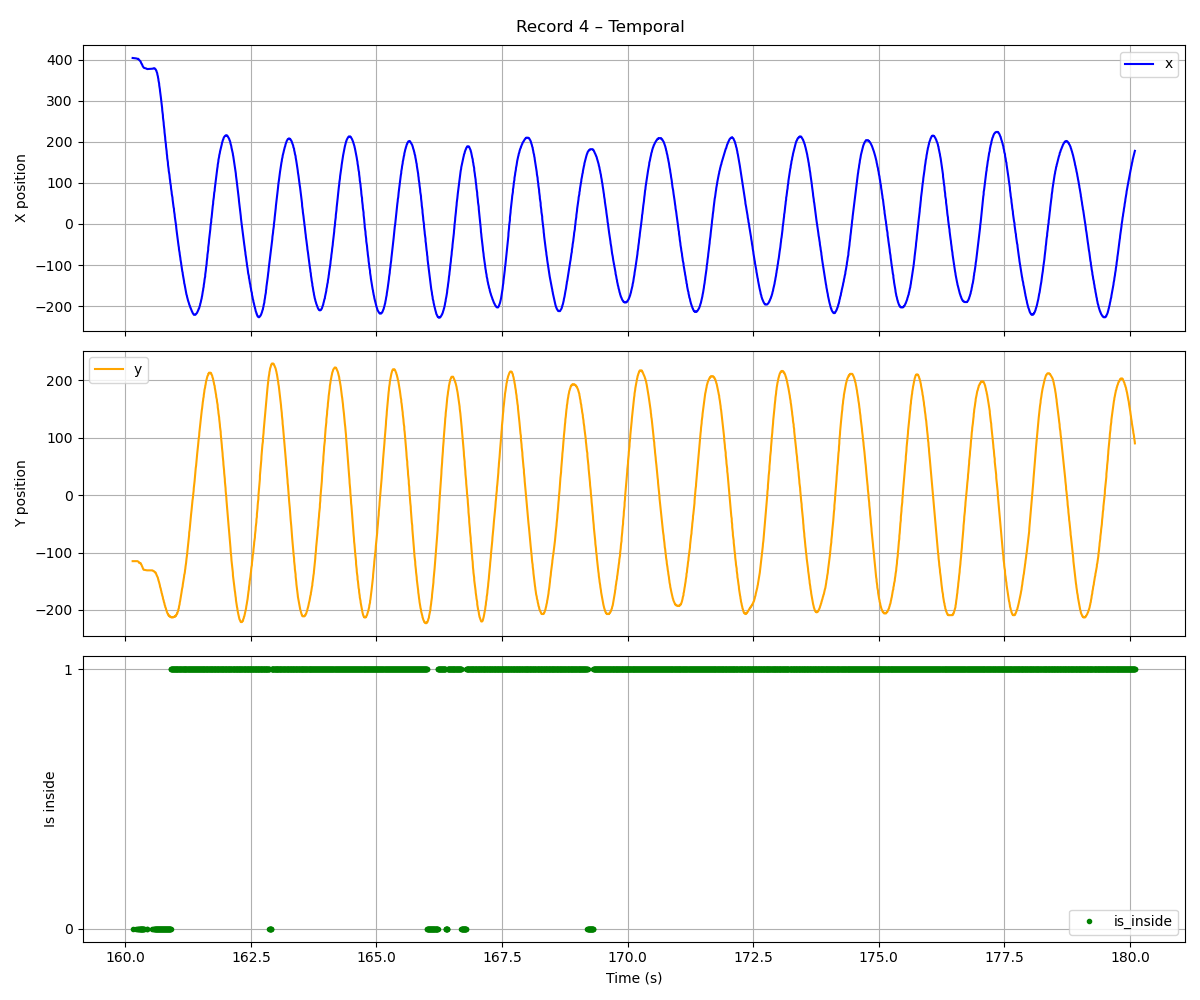

In [10]:
# =============================================================
# 1) Fonction de plot spatial par record
# =============================================================
def plot_record_spatial(seg, idx):
    fig, ax = plt.subplots(figsize=(8, 8))

    # ----- screen
    sw = float(record_config["screenWidth"])
    sh = float(record_config["screenHeight"])
    ax.plot(
        [-sw/2, sw/2, sw/2, -sw/2, -sw/2],
        [ sh/2, sh/2, -sh/2, -sh/2,  sh/2],
        color="magenta",
        label="screen"
    )

    # ----- target (corrigée)
    theta = np.linspace(0, 2*np.pi, 500)
    ax.fill(R_ext*np.cos(theta), R_ext*np.sin(theta),
            color="yellow", alpha=0.4, label="target")
    ax.fill(R_int*np.cos(theta), R_int*np.sin(theta),
            color="white")

    # ----- inside / outside
    inside_mask = seg["inside"]
    outside_mask = ~inside_mask

    ax.scatter(seg["x"][inside_mask], seg["y"][inside_mask],
               s=4, c="green", label="inside")

    ax.scatter(seg["x"][outside_mask], seg["y"][outside_mask],
               s=8, c="red", label="outside")

    ax.set_aspect("equal")
    ax.set_title(f"Record {idx}")
    ax.set_xlabel("X (pixels)")
    ax.set_ylabel("Y (pixels)")
    #legend à droite centrée
    plt.legend(
        loc="center right",
        bbox_to_anchor=(1, 0.5),
        frameon=True
    )
    plt.show()


# =============================================================
# 2) Fonction de plot temporel par record
# =============================================================
def plot_record_temporal(seg, idx):
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # --- x(t)
    axs[0].plot(seg["t"], seg["x"], color="blue", label="x")
    axs[0].set_ylabel("X position")
    axs[0].grid(True)
    axs[0].legend()

    # --- y(t)
    axs[1].plot(seg["t"], seg["y"], color="orange", label="y")
    axs[1].set_ylabel("Y position")
    axs[1].grid(True)
    axs[1].legend()

    # --- inside(t)
    axs[2].plot(
        seg["t"], seg["inside"].astype(int),
        color="green", marker="o", linestyle="none", markersize=3,
        label="is_inside"
    )
    axs[2].set_ylabel("Is inside")
    axs[2].set_yticks([0, 1])
    axs[2].set_xlabel("Time (s)")
    axs[2].grid(True)
    axs[2].legend()

    fig.suptitle(f"Record {idx} – Temporal")
    plt.tight_layout()
    plt.show()


# =============================================================
# 3) Boucle : pour chaque record → spatial puis temporel
# =============================================================
segments = []

inside_global = data["mouseInTarget"].astype(bool)   

for start, end in zip(record_starts, record_ends):

    mask = (t >= start) & (t <= end)

    seg = {
        "t": t[mask],
        "x": x[mask],
        "y": y[mask],
        "inside": inside_global[mask]   
    }

    segments.append(seg)

#Compute radius for target
inside_mask = inside_global  # True if the point is inside the target
r = np.sqrt(x[inside_mask]**2 + y[inside_mask]**2) # radius
R_ext = r.max()  
R_int = r.min()  

for i, seg in enumerate(segments):
    plot_record_spatial(seg, i)
    plot_record_temporal(seg, i)
